# Forecasting Home Prices in Boston by Kevin Tran

This dataset is pulled directly from Redfin, a real estate website with actual housing listings. I will do an indepth analysis with Python. Then I will create a regression model to predict the housing prices.

Data source: https://1drv.ms/u/s!Aiy11TUSNrfWjBw7ZaSyrTpmBOBt?e=iEMOcB (Need to fix)

Description of variables: \
SOLD DATE \
PROPERTY TYPE: Condo/Co-op, Multi-Family (2-4 Unit), Single Family Residential, and Townhouse \
ADDRESS \
CITY \
STATE: Massachusetts (MA) \
ZIP OR POSTAL CODE \
PRICE: Price of property \
BEDS \
BATHS \
LOCATION \
SQUARE FEET \
LOT SIZE: The square feet inside the home plus the yard\
YEAR BUILT \
DAYS ON MARKET \
$/SQUARE FEET \
HOA/MONTH: Homeowners assocation fee

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
%matplotlib inline
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)

# Data Cleansing

In [2]:
df_boston = pd.read_csv('Boston.csv') 

print(df_boston.describe())
print(df_boston.info())

       ZIP OR POSTAL CODE         PRICE          BEDS         BATHS  \
count        13108.000000  1.310800e+04  12996.000000  13016.000000   
mean          2203.631294  8.775019e+05      2.926670      2.032018   
std            814.451349  7.844380e+05      1.868784      1.222487   
min           1212.000000  1.750000e+02      0.000000      1.000000   
25%           2127.000000  5.050000e+05      2.000000      1.000000   
50%           2135.000000  6.750000e+05      3.000000      2.000000   
75%           2171.000000  9.700000e+05      4.000000      2.500000   
max          92459.000000  2.300000e+07     78.000000     44.000000   

        SQUARE FEET      LOT SIZE    YEAR BUILT  DAYS ON MARKET  \
count  13031.000000  7.222000e+03  13025.000000    11437.000000   
mean    1713.690891  1.308472e+05   1940.917466      180.136487   
std     1207.817329  3.350075e+06     48.243385       99.933510   
min        1.000000  2.200000e+01   1095.000000        1.000000   
25%      979.000000  2.00

In [3]:
df_boston = df_boston.dropna(axis=0, subset=('SOLD DATE', 'BEDS','BATHS','LOCATION','DAYS ON MARKET','STATUS', 'SQUARE FEET', 'LOT SIZE')) 
df_boston = df_boston.drop(['SALE TYPE','STATUS','NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME','URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)','SOURCE','MLS#','FAVORITE','INTERESTED'],axis=1) 

In [4]:
condition_1 = df_boston['PROPERTY TYPE'] != 'Mobile/Manufactured Home'
condition_2 = df_boston['PROPERTY TYPE'] != 'Other' 
condition_3 = df_boston['PROPERTY TYPE'] != 'Parking'  
condition_4 = df_boston['PROPERTY TYPE'] != 'Vacant Land'
condition_5 = df_boston['PROPERTY TYPE'] != 'Multi-Family (5+ Unit)'

df_boston = df_boston[condition_1 & condition_2 & condition_3 & condition_4 & condition_5]

In [5]:
df_boston.shape

(7047, 18)

# Desciptive Statistics  

## Map of Boston

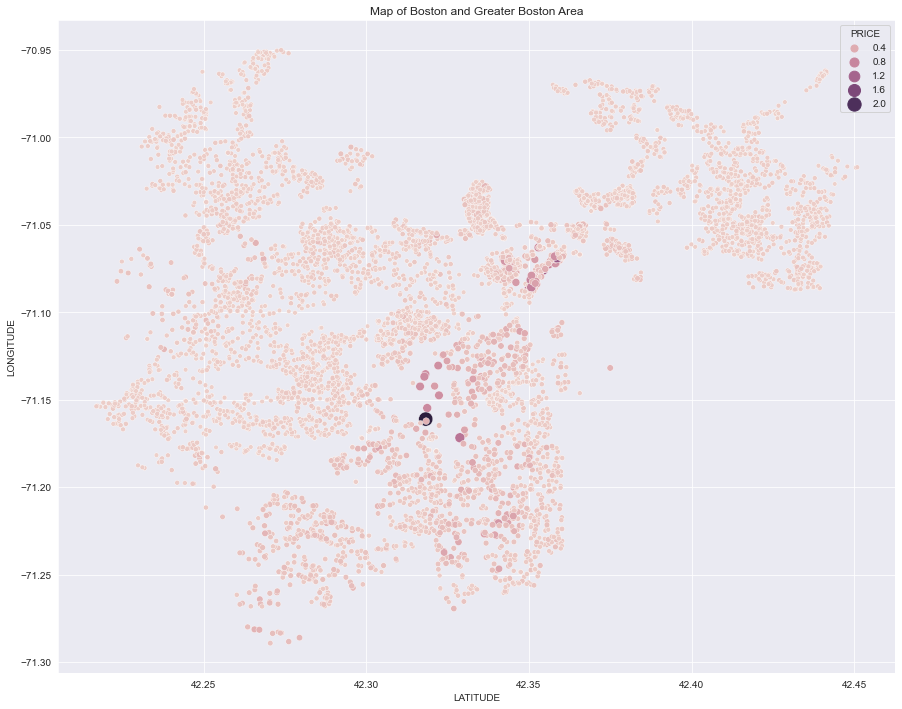

In [6]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='LATITUDE',y= 'LONGITUDE',hue='PRICE',size='PRICE',data=df_boston,sizes=(20, 200))
plt.title('Map of Boston and Greater Boston Area')
plt.show()

Brookline, MA has the most expensive home in this dataset at $23,000,000 including some of the most expensive homes in the dataset

## Average Price by Zip Code

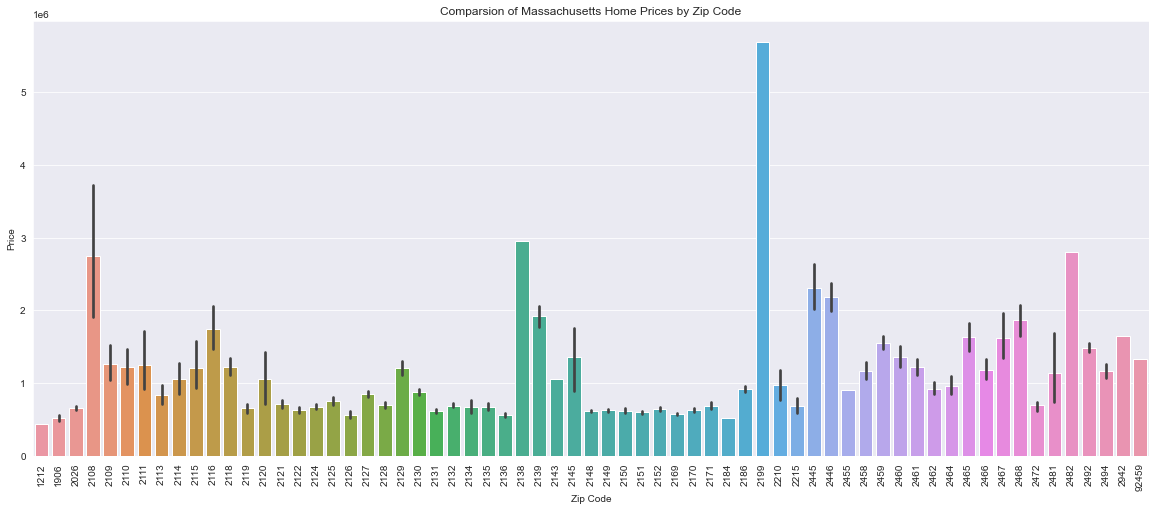

In [8]:
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.barplot(x='ZIP OR POSTAL CODE', y='PRICE', data=df_boston)
plt.xticks(rotation=90)
plt.xlabel('Zip Code')
plt.ylabel('Price')
plt.title('Comparsion of Massachusetts Home Prices by Zip Code')
plt.show()

Zip code: 02199 - Back Bay has the highest average home prices

## Variance Boxplot

<Figure size 1440x576 with 0 Axes>

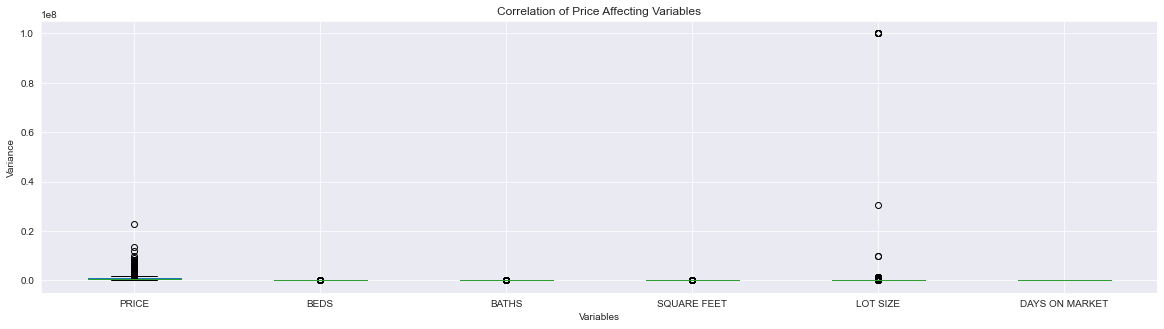

In [9]:
ListOfVariables = ['PRICE', 'BEDS','BATHS','SQUARE FEET','LOT SIZE', 'DAYS ON MARKET']

df_boston_box = df_boston[ListOfVariables] 
plt.figure(figsize=(20,8))
df_boston_box.plot(kind='box')
plt.xlabel('Variables')
plt.ylabel('Variance')
plt.title('Correlation of Price Affecting Variables')
plt.show()

There is a lot of variance for Price and Lot Size. Removing the outliers would better focus the analysis 

## Home Prices in Boston

Text(0.5, 1.0, 'Housing Prices in Boston')

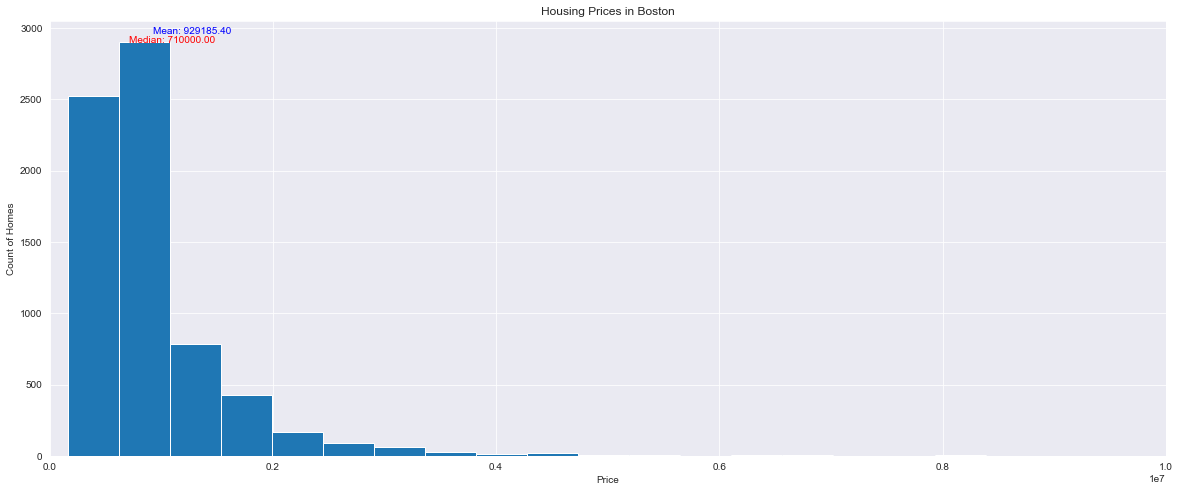

In [10]:
plt.figure(figsize=(20,8))

plt.hist(df_boston['PRICE'], bins=50)

plt.xlabel('Price')
plt.ylabel('Count of Homes')
min_ylim, max_ylim = plt.ylim()
plt.xlim(0,10000000)
plt.text(df_boston['PRICE'].mean(), max_ylim*.97, 'Mean: {:.2f}'.format(df_boston['PRICE'].mean()), color='blue')
plt.text(df_boston['PRICE'].median(), max_ylim*.95, 'Median: {:.2f}'.format(df_boston['PRICE'].median()), color='red')

plt.title('Housing Prices in Boston')

With an average price of 929,185 and a median of 710,000, home prices in Boston + Greater Boston area are a bit higher than anticipated. If outliers are removed then then prices will likely drop to more reasonable prices

## Price Distribution by Property Type

Text(767.2554347826087, 0.5, 'Property Type')

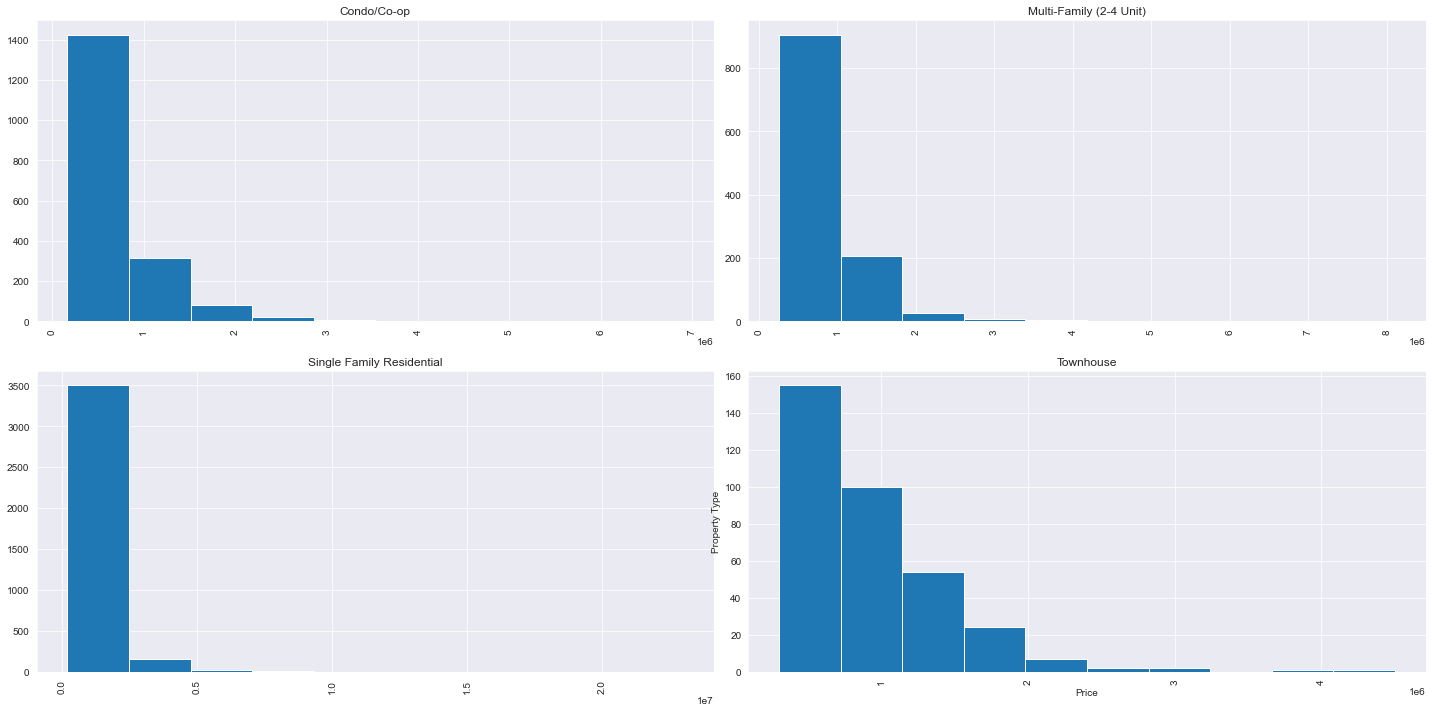

In [11]:
df_boston.hist(column='PRICE',by='PROPERTY TYPE',figsize=(20, 10))
plt.tight_layout()
plt.xlabel('Price')
plt.ylabel('Property Type')

On this histogram we see the different property types and the distribution of price on quadrants are shifted all the way to the left

## Correlation of Variables to Price

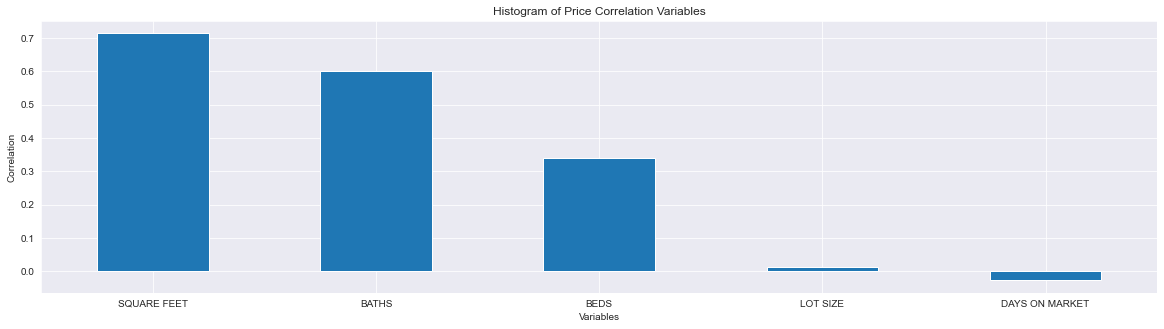

In [12]:
df_boston[ListOfVariables].corr()['PRICE'][1:].sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0) 
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Histogram of Price Correlation Variables')
plt.show()

Price is the most heavily correlated with Square Feet and Baths and then Beds. This was a bit surprising to me because I thought people would value bedrooms more in a home and therefore contribute more to the price of a home than bathrooms. 

### Insights
1. Bathrooms contributed more to the price of a home in Boston/Greater Boston are than Bedrooms did
2. Downtown Boston has the most expensive homes
3. Cambridge, a surburb of Boston, have the highest averages homes in the Boston area.

## Outliers

In [13]:
Q1 = df_boston.quantile(0.25)
Q3 = df_boston.quantile(0.75)
IQR = Q3-Q1

index = df_boston.index
df_boston_pre = len(index)
print("Number of entries before removing outliers: " + str(df_boston_pre))

lower_limit = Q1 - 1.5*IQR 
upper_limit = Q3 + 1.5*IQR

print(lower_limit['PRICE'])
print(upper_limit['PRICE'])

df_outliers = df_boston[(df_boston['PRICE'] > lower_limit['PRICE']) & (df_boston['PRICE'] < upper_limit['PRICE'])]
index_1 = df_outliers.index
df_boston_post = len(index_1)
print("Number of entries after removing outliers: " + str(df_boston_post))

df_result = 1 - len(df_outliers) / len(df_boston)

print("Percent of data that are outliers: " + str(df_result))

Number of entries before removing outliers: 7047
-162500.0
1737500.0
Number of entries after removing outliers: 6434
Percent of data that are outliers: 0.08698737051227468


## Map of Boston - Non Outliers

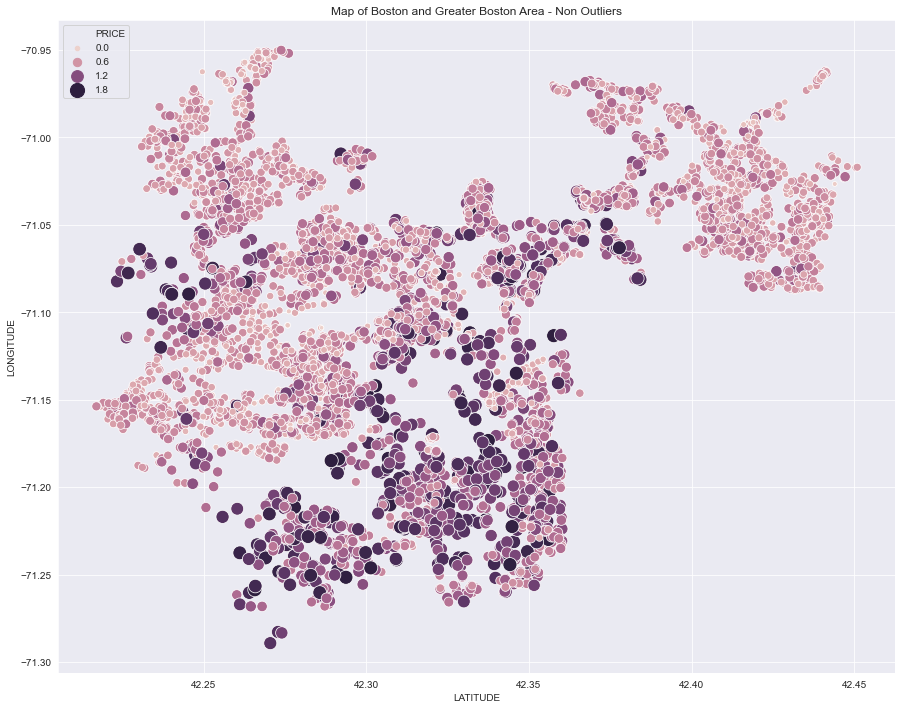

In [14]:
plt.figure(figsize=(15,12))
sns.scatterplot(x='LATITUDE',y= 'LONGITUDE',hue='PRICE',size='PRICE',data=df_outliers,sizes=(20, 200))
plt.title('Map of Boston and Greater Boston Area - Non Outliers')
plt.show()

We see a much darker pattern acrosst he map indicating a more center distribution and lack of outliers

## Average Price by Zip Code - Non Outliers

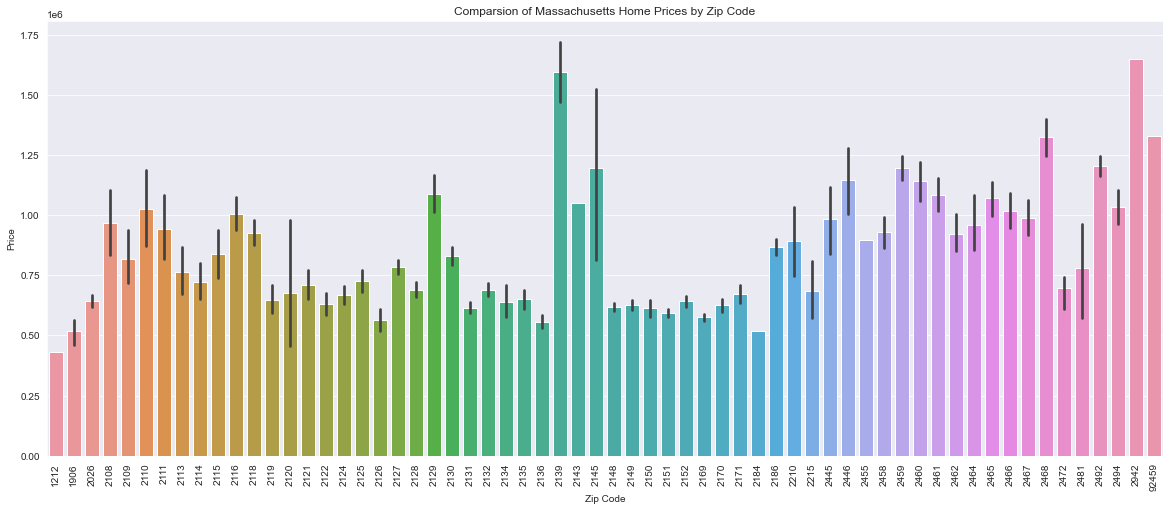

In [15]:
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.barplot(x='ZIP OR POSTAL CODE', y='PRICE', data=df_outliers)
plt.xticks(rotation=90)
plt.xlabel('Zip Code')
plt.ylabel('Price')
plt.title('Comparsion of Massachusetts Home Prices by Zip Code')
plt.show()

We see that Cambridge no longer has the highest average home pries in the Boston area, it's Needham, MA

## Variance Boxplot - Non Outliers

<Figure size 1440x576 with 0 Axes>

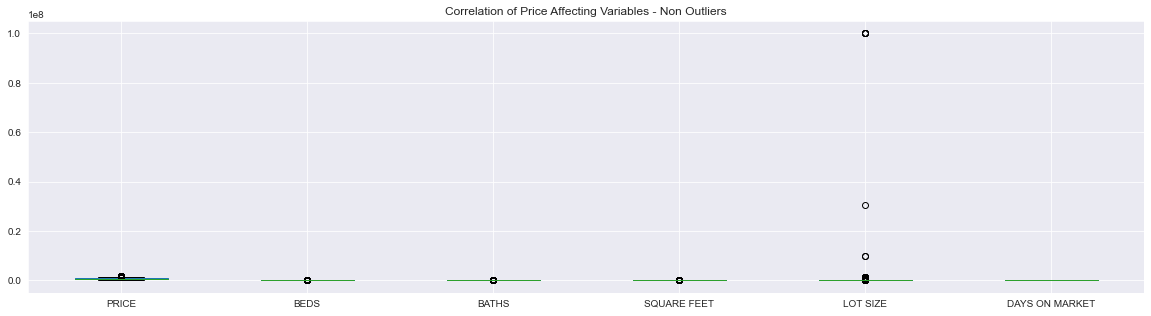

In [16]:
df_outliers_box = df_outliers[ListOfVariables] 
plt.figure(figsize=(20,8))
df_outliers_box.plot(kind='box')
plt.title('Correlation of Price Affecting Variables - Non Outliers')
plt.show()

Very little difference between this with outliers and non outliers. Some of the extreme values for Price was removed. 

## Home Prices in Boston - Non Outliers

Text(0.5, 1.0, 'Mean Housing Prices in Boston - Non Outliers')

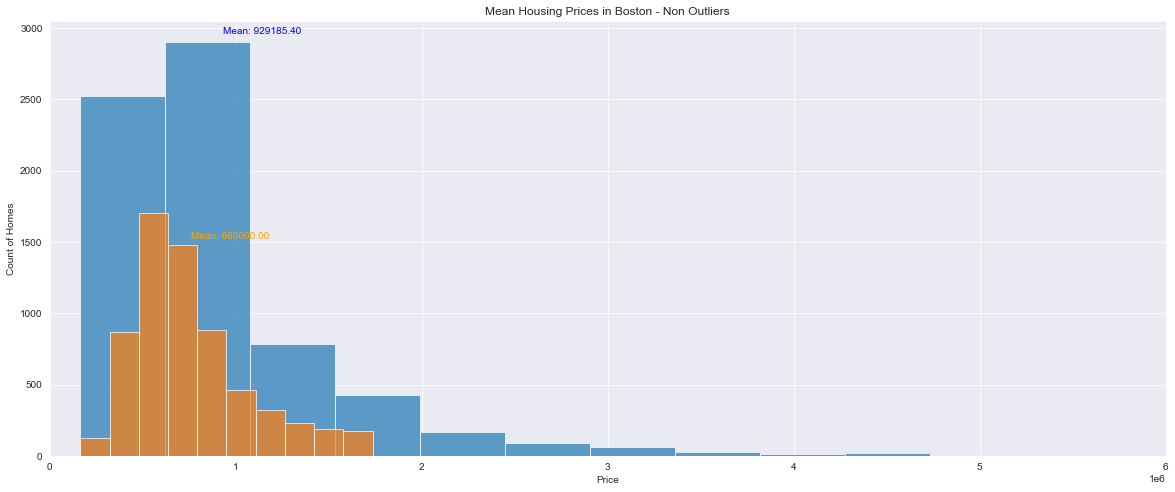

In [17]:
plt.figure(figsize=(20,8))

plt.hist(df_boston['PRICE'],bins=50,alpha=0.7,label='Price with outliers')
plt.hist(df_outliers['PRICE'],bins=10,alpha=0.7,label='Price without outliers')

plt.xlabel('Price')
plt.ylabel('Count of Homes')

min_ylim, max_ylim = plt.ylim()
plt.xlim(0,6000000)
plt.text(df_boston['PRICE'].mean(),max_ylim*.97,'Mean: {:.2f}'.format(df_boston['PRICE'].mean()),color='blue')
plt.text(df_outliers['PRICE'].mean(),max_ylim*.5,'Mean: {:.2f}'.format(df_outliers['PRICE'].median()),color='orange')

plt.title('Mean Housing Prices in Boston - Non Outliers')

Text(0.5, 1.0, 'Median Housing Prices in Boston - Non Outliers')

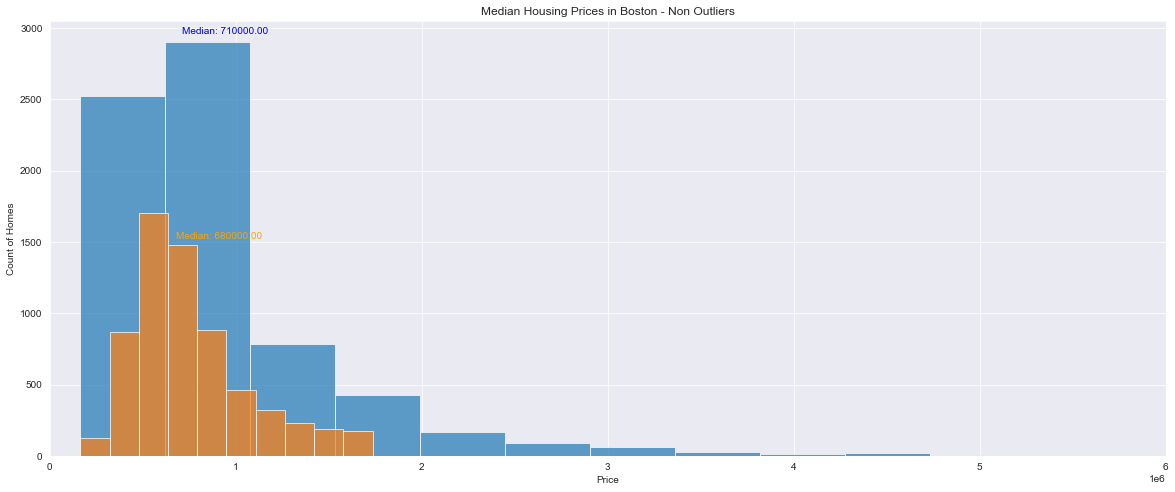

In [18]:
plt.figure(figsize=(20,8))

plt.hist(df_boston['PRICE'],bins=50,alpha=0.7,label='Price with outliers')
plt.hist(df_outliers['PRICE'],bins=10,alpha=0.7,label='Price without outliers')

plt.xlabel('Price')
plt.ylabel('Count of Homes')

min_ylim, max_ylim = plt.ylim()
plt.xlim(0,6000000)
plt.text(df_boston['PRICE'].median(),max_ylim*.97,'Median: {:.2f}'.format(df_boston['PRICE'].median()),color='blue')
plt.text(df_outliers['PRICE'].median(),max_ylim*.5,'Median: {:.2f}'.format(df_outliers['PRICE'].median()),color='orange')

plt.title('Median Housing Prices in Boston - Non Outliers')

Outliers accounted for only 8% of the data and even with this we still a drastic difference in the mean/distribution of the two histograms

## Price Distribution by Property Type - Non Outliers

Text(772.8804347826087, 0.5, 'Property Type')

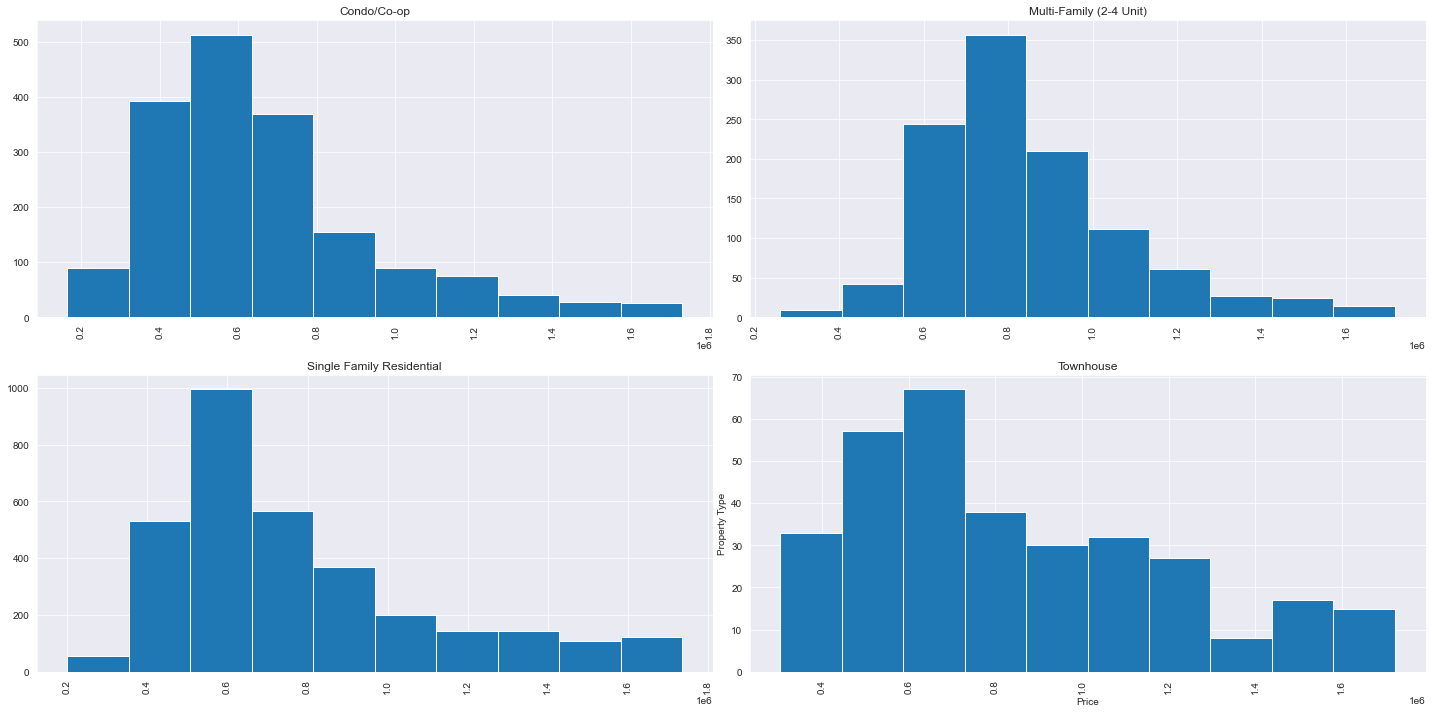

In [19]:
df_outliers.hist(column='PRICE',by='PROPERTY TYPE',figsize=(20, 10))
plt.tight_layout()
plt.xlabel('Price')
plt.ylabel('Property Type')

These histograms have shifted more to the right and some have even become more evenly distributed in quadrants I, II, and III. 

## Correlation of Variables to Price - Non Outliers

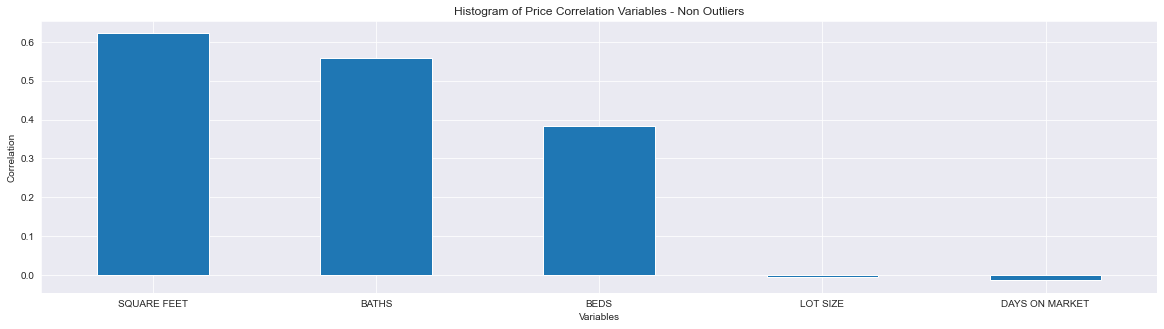

In [20]:
df_outliers[ListOfVariables].corr()['PRICE'][1:].sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0) 
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Histogram of Price Correlation Variables - Non Outliers')
plt.show()

The correlation of the top three variables from df_boston have remained in the same order expect the last two variables are now negligible. 

### Insights - Non Outliers
1. Removing outliers made a huge impact for most of the plots
2. Drastically changed the outcome of the analysis for the map, average price of homes by zip code, and price distribution by property type
3. Square Feet, baths, and beds still were the most correlated variables with price and increased it's correlated with outliers removed

# Inferential Statistics

## Heatmaps

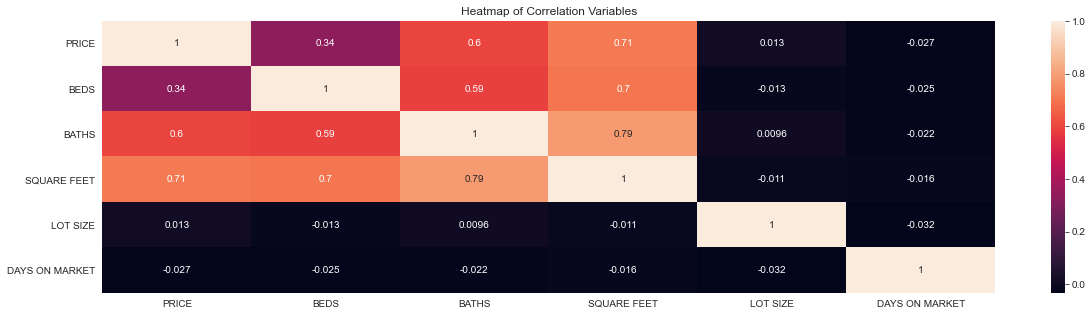

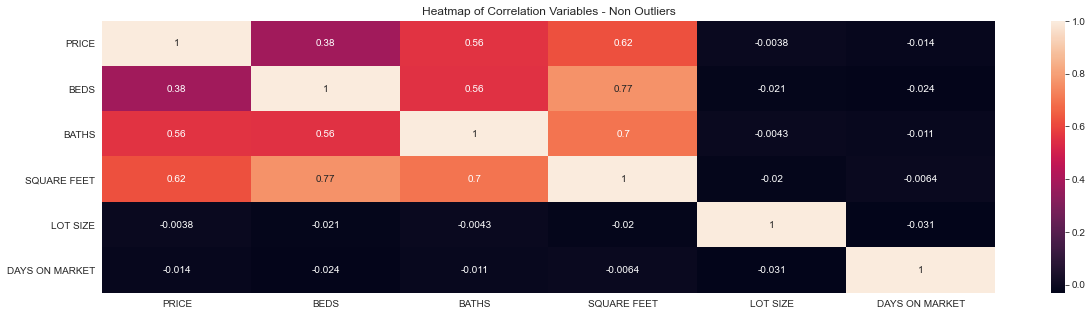

In [21]:
sns.heatmap(df_boston[ListOfVariables].corr(),annot=True)
plt.title('Heatmap of Correlation Variables')
plt.show()

sns.heatmap(df_outliers[ListOfVariables].corr(),annot=True)
plt.title('Heatmap of Correlation Variables - Non Outliers')
plt.show()

In [22]:
boston_correlation = df_boston[ListOfVariables].corr()
b_correlation = boston_correlation.loc[:,['PRICE']]
b_correlation = b_correlation.sort_values(by='PRICE',ascending=False).drop('PRICE')
print(b_correlation)

outlier_correlation = df_outliers[ListOfVariables].corr()
o_correlation = outlier_correlation.loc[:,['PRICE']]
o_correlation = o_correlation.sort_values(by='PRICE',ascending=False).drop('PRICE')
print(o_correlation)

                   PRICE
SQUARE FEET     0.713338
BATHS           0.599094
BEDS            0.338568
LOT SIZE        0.012843
DAYS ON MARKET -0.026874
                   PRICE
SQUARE FEET     0.621830
BATHS           0.558864
BEDS            0.382751
LOT SIZE       -0.003794
DAYS ON MARKET -0.013739


## OLS Regression

### With Outliers

In [32]:
independent_variables = df_boston[['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'DAYS ON MARKET']]
dependent_variables = df_boston['PRICE']

x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(independent_variables, dependent_variables, test_size=0.33, random_state=42)

boston_model = sm.OLS(y_train_b, x_train_b).fit()
boston_predictions = boston_model.predict(x_test_b)

print(boston_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.821
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                              4321.
Date:                Mon, 03 May 2021   Prob (F-statistic):                        0.00
Time:                        11:19:59   Log-Likelihood:                         -68820.
No. Observations:                4721   AIC:                                  1.377e+05
Df Residuals:                    4716   BIC:                                  1.377e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

### Without Outliers 

In [24]:
independent_variables = df_outliers[['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'DAYS ON MARKET']]
dependent_variables = df_outliers['PRICE']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(independent_variables, dependent_variables, test_size=0.33, random_state=42)

outlier_model = sm.OLS(y_train_o, x_train_o).fit()
outlier_predictions = outlier_model.predict(x_test_o)

print(outlier_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.897
Method:                 Least Squares   F-statistic:                              7503.
Date:                Mon, 03 May 2021   Prob (F-statistic):                        0.00
Time:                        08:54:01   Log-Likelihood:                         -59916.
No. Observations:                4310   AIC:                                  1.198e+05
Df Residuals:                    4305   BIC:                                  1.199e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

### Insights
Based on the R-square value I can help clients predict the price of a home with 90% accuracy. 

## Predictions 

### With Outliers 

         Prediction  Test Data
7004   8.756671e+05     499000
12354  8.399180e+05     670000
4674   2.904220e+05     439900
6945   3.649651e+05     537000
8110   7.125427e+05     775000
10885  1.533505e+06    1400000
981    6.599173e+05     865000
12933  1.535457e+06     950000
1103   6.327517e+05     910000
3179   7.621865e+05     540000
293    1.398820e+06     800000
2862   9.874319e+05    1880000
7867   9.853870e+05    1865000
13046  5.768220e+05     410000
8443   1.003417e+06    1300000
6065   6.694725e+05    1039000
1102   3.733765e+05     199000
10536  8.593398e+05     685000
5054   4.055264e+05     650000
12757  9.591336e+05     750000


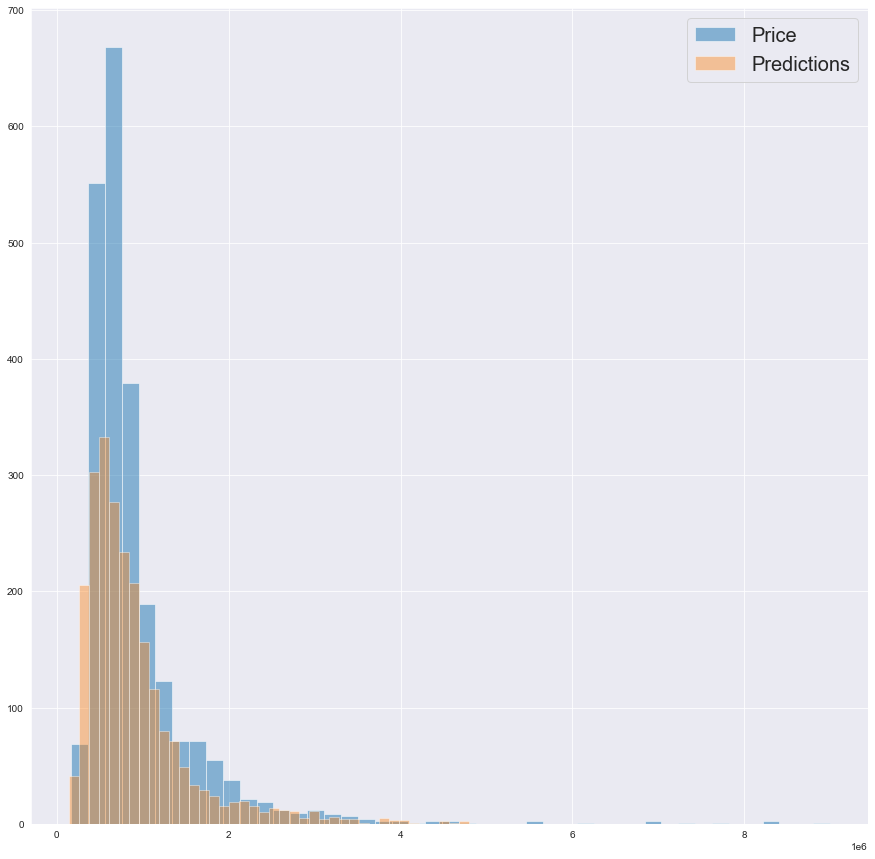

293490.96656610793


In [25]:
plt.rcParams['figure.figsize'] = (15,15)
boston_predict = boston_predictions.reset_index()[0]

compare = pd.DataFrame({'Prediction': boston_predictions, 'Test Data' : y_test_b})
print(compare.head(20))

plt.hist(y_test_b,bins=45,alpha=0.5,label='Price')
plt.hist(boston_predictions,bins=40,alpha=0.4, label='Predictions')
plt.legend(loc='upper right',prop={'size':20})

plt.show()

print(mean_absolute_error(y_test_b, boston_predictions))

### Without Outliers

         Prediction  Test Data
5599   6.031559e+05    1100000
7714   7.729576e+05     935000
567    5.901629e+05     510000
8442   7.082841e+05     790000
10759  8.212061e+05     734000
10505  6.212617e+05     505000
9048   4.999240e+05     520000
3911   8.276883e+05     745000
6306   7.477347e+05     750000
3915   8.261761e+05     790000
2075   1.323058e+06    1400000
2796   1.181210e+06    1200000
3954   5.453723e+05     555000
2135   7.010807e+05    1599000
11803  5.212363e+05     618000
8494   9.483935e+05    1650000
4644   6.058789e+05     950000
10673  1.407572e+06    1368000
12324  8.542932e+05     538000
1900   1.136884e+06    1250000


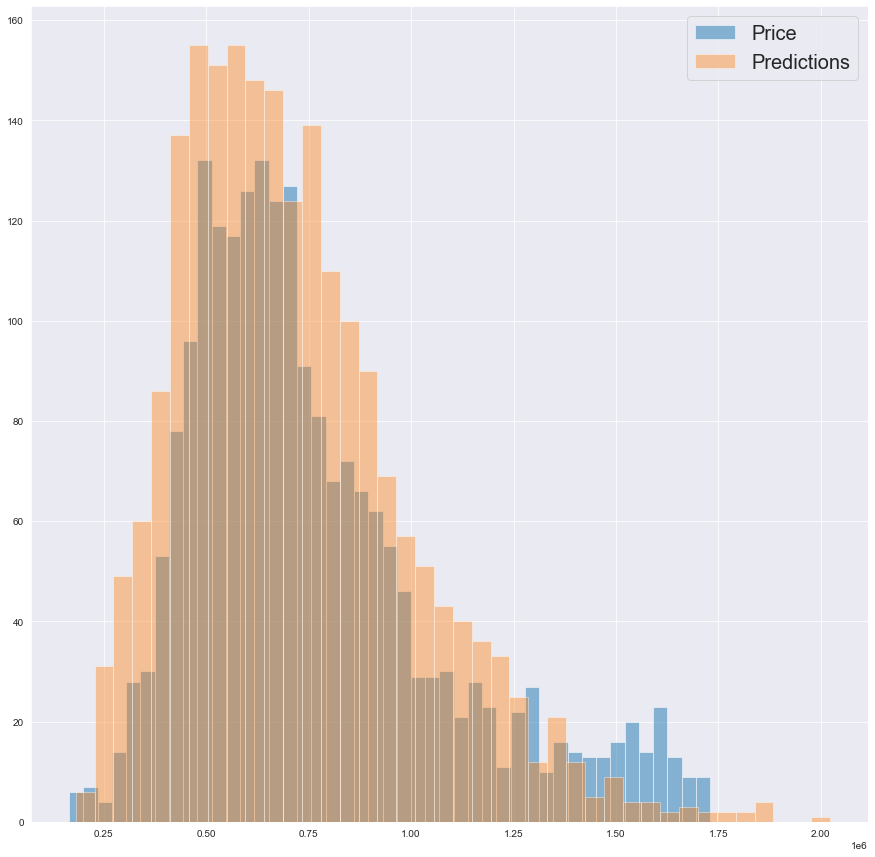

196455.90416204187


In [26]:
plt.rcParams['figure.figsize'] = (15,15)
outlier_predict = outlier_predictions.reset_index()[0]

compare = pd.DataFrame({'Prediction': outlier_predictions, 'Test Data' : y_test_o})
print(compare.head(20))

plt.hist(y_test_o,bins=45,alpha=0.5,label='Price')
plt.hist(outlier_predictions,bins=40,alpha=0.4, label='Predictions')
plt.legend(loc='upper right',prop={'size':20})

plt.show()

print(mean_absolute_error(y_test_o, outlier_predictions))

### Predictions

In [30]:
df_outliers.to_csv('BostonPrediction.csv')